In [66]:
email_both = True
send_email = True

In [1]:
import asyncio
asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())
import backtrader as bt
import pandas as pd
import numpy as np
import random
import pytz
import time
import os
from xbbg import blp
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, Dropdown, HBox, VBox, Button, Output, Text, widgets
import sympy as sp
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, update_display
from IPython import get_ipython
# import backtrader.plot as btplot
import matplotlib.dates as mdates
from pydataquery import DataQuery
import re
import statsmodels.api as sm
from scipy.optimize import minimize
import scipy.stats as stats
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import yfinance as yf
import uuid
from concurrent.futures import ThreadPoolExecutor
import warnings
warnings.filterwarnings('ignore')

##### Style df
def bold_zscore(val):
    return 'font-weight: bold' if val else ''

def add_black_line(row):
    return ['border-bottom: 3px solid black' if row.name in [2, 7, 13, 15, 17, 21] else '' for _ in row]

def color_negative_red_positive_green_basis(col: pd.Series):
    if col.empty:
        return ['' for _ in col]

    def safe_float(x):
        try:
            return float(x)
        except (ValueError, TypeError):
            return None

    float_col = col.apply(safe_float)
    min_val = float_col.min(skipna=True)
    max_val = float_col.max(skipna=True)

    def value_to_color(val):
        if val is None:
            return ''
        if val < 0 and min_val < 0:
            frac = val / min_val
            frac = max(min(frac, 1), 0)
            r = int(255 - (255 - 87) * frac)
            g = int(255 - (255 - 187) * frac)
            b = int(255 - (255 - 138) * frac)
            return f'background-color: rgba({r},{g},{b},0.75)'
        elif val > 0 and max_val > 0:
            frac = val / max_val
            frac = max(min(frac, 1), 0)
            r = int(255 - (255 - 230) * frac)
            g = int(255 - (255 - 135) * frac)
            b = int(255 - (255 - 115) * frac)
            return f'background-color: rgba({r},{g},{b},0.75)'
        return ''

    return [value_to_color(v) for v in float_col]

In [2]:
# ################################## Updating betas of all pairs
# all_start_date = '2020-01-01'#str((datetime.now()-timedelta(days=365*2.5)).date())

# labels = {
#         "ER CDX IG 5Y": "DB(CDS,TRAC-X,NAMERI100UNF05ONRUN,JPM_RETURN)",
#         "ER CDX IG 10Y": "DB(CDS,TRAC-X,NAMERI100UNF10ONRUN,JPM_RETURN)",
#         "ER CDX HY 5Y": "DB(CDS,TRAC-X,NAHY100UNF05ONRUN,JPM_RETURN)",
#         # "ER CDX HY 10Y": "DB(CDS,TRAC-X,NAHY100UNF10ONRUN,JPM_RETURN)",
#         "ER CDX EM 5Y": "DB(NEO-UK,credit/cds/index/cdxEM-onrun/5y/JPM_RETURN)",
#         "ER ITRX MAIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx-onrun/5y/JPM_UNFUNDED_INDEX)",
#         "ER ITRX MAIN 10Y": "DB(NEO-UK,credit/cds/index/itraxx-onrun/10y/JPM_UNFUNDED_INDEX)",
#         "ER ITRX XOVER 5Y": "DB(NEO-UK,credit/cds/index/itraxx_crossover-onrun/5y/JPM_UNFUNDED_INDEX)",
#         # "ER ITRX XOVER 10Y": "DB(NEO-UK,credit/cds/index/itraxx_crossover-onrun/10y/JPM_UNFUNDED_INDEX)",
#         # "ER ITRX SNRFIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx_senfin-onrun/5y/JPM_UNFUNDED_INDEX)",
#         # "ER ITRX SUBFIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx_subfin-onrun/5y/JPM_UNFUNDED_INDEX)",
#         "CDX IG 5Y": "DB(CDS,TRAC-X,NAMERI100UNF05ONRUN,JPM_CDSSPREAD_MID)",
#         "CDX IG 10Y": "DB(CDS,TRAC-X,NAMERI100UNF10ONRUN,JPM_CDSSPREAD_MID)",
#         "CDX HY 5Y": "DB(CDS,TRAC-X,NAHY100UNF05ONRUN,JPM_CDSSPREAD_MID)",
#         # "CDX HY 10Y": "DB(CDS,TRAC-X,NAHY100UNF10ONRUN,JPM_CDSSPREAD_MID)",
#         "ITRX MAIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx-onrun/5y/JPM_CDSSPREAD_MID)",
#         "ITRX MAIN 10Y": "DB(NEO-UK,credit/cds/index/itraxx-onrun/10y/JPM_CDSSPREAD_MID)",
#         "ITRX XOVER 5Y": "DB(NEO-UK,credit/cds/index/itraxx_crossover-onrun/5y/JPM_CDSSPREAD_MID)",
#         # "ITRX XOVER 10Y": "DB(NEO-UK,credit/cds/index/itraxx_crossover-onrun/10y/JPM_CDSSPREAD_MID)",
#         # "ITRX SNRFIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx_senfin-onrun/5y/JPM_CDSSPREAD_MID)",
#         # "ITRX SUBFIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx_subfin-onrun/5y/JPM_CDSSPREAD_MID)",
#         "CDX EM 5Y": "DB(NEO-UK,credit/cds/index/cdxEM-onrun/5y/JPM_CDSSPREAD_MID)",
# }

# dq = DataQuery(
# client_id='jbAIMF2Tkp0JO3sc',
# client_secret='d7qfzgt55pddjs352sgxosFyI4t2eja07k7opbi6wg9oqjc1OjkdAksn1btmnugeMjchcx2vwTsJupw',
# )

# job = dq.create_job(expressions = list(labels.values()))
# dq.start_date = all_start_date
# var = job.execute()
# df = job.to_pivot_table()
# df = df.T
# df.index = pd.to_datetime(df.index, format='%Y%m%d').date
# df.index.name = 'Date'

# df.rename(columns={v:k for k, v in labels.items()},inplace=True)
# df.columns.name = None
# clear_output(wait=False)
# df = df.dropna(how='all')
# df = df.dropna(axis=1, how='all')

# dfx = df.copy()
# dfx.index = pd.to_datetime(dfx.index)

# end_date = dfx.index[-1]
# df_pairs = dfx.copy()
# dfx = dfx.resample('W').last()
# master_dfx = (dfx.diff(1))/dfx.shift(1)

# start_date = all_start_date

# securities = ['HYG US Equity','EMB US Equity','LQD US Equity','VCIT US Equity','IEAC LN Equity','IHYG LN EQUITY','BKLN US EQUITY']
# securities = ['HYG US Equity','EMB US Equity','VCIT US Equity',]
# fields1 = ['YAS_MOD_DUR']
# df = blp.bdh(tickers=securities, start_date = start_date, end_date = end_date, flds = fields1)
# df.columns = [item.split(' ')[0] + ' DUR' for item in securities]
# df1 = df.copy()

# securities = ['LT03TRUU INDEX','LT09TRUU INDEX','QW3I INDEX', 'LT03MD INDEX','LT09MD INDEX']
# fields = ['PX_LAST']
# df = blp.bdh(tickers=securities, start_date = start_date, end_date = end_date, flds = fields)
# df.columns = ['TR ' + item.split(' ')[0] for item in securities[:3]] + [item.split(' ')[0] + ' DUR' for item in securities[:2]]
# df1 = pd.concat([df,df1],axis=1)

# securities = ['HYG US Equity','EMB US Equity','VCIT US Equity',]
# fields = ['TOT_RETURN_INDEX_GROSS_DVDS']
# df = blp.bdh(tickers=securities, start_date = start_date, end_date = end_date, flds = fields)
# df.columns = ['TR ' + item.split(' ')[0] for item in securities] 
# df1 = pd.concat([df,df1],axis=1)

# securities = ['QW3I INDEX']
# fields = ['MODIFIED_DURATION']
# df = blp.bdh(tickers=securities, start_date = start_date, end_date = end_date, flds = fields)
# df.columns = [item.split(' ')[0] + ' DUR' for item in securities]
# df1 = pd.concat([df,df1],axis=1)

# securities = ['SPXFP INDEX', 'RTYFPE INDEX']
# fields = ['PX_LAST']
# df = blp.bdh(tickers=securities, start_date = start_date, end_date = end_date, flds = fields)
# df.columns = ['ER SPX','ER RTY']
# df1 = pd.concat([df,df1],axis=1)

# securities = ['SPX INDEX', 'RSP US EQUITY', 'RTY INDEX']
# fields = ['TOT_RETURN_INDEX_GROSS_DVDS']
# df = blp.bdh(tickers=securities, start_date = start_date, end_date = end_date, flds = fields)
# df.columns = ['TR ' + item.split(' ')[0] for item in securities] 
# df1 = pd.concat([df,df1],axis=1)

# df1.sort_index(inplace=True)
# all_dq_initial_data = df1.copy()

# ############################################### bbg_data
# bbg_tick = ['HYG US Equity','EMB US Equity','VCIT US Equity',\
#             'LT03TRUU INDEX','LT09TRUU INDEX',
#            'QW3I INDEX']

# fields1 = ['TOT_RETURN_INDEX_GROSS_DVDS']
# df = blp.bdh(tickers = bbg_tick, start_date = start_date, end_date = end_date, flds = fields1)
# df.columns = ['TR ' + list(item)[0].split(' ')[0] for item in list(df.columns)]
# all_bbg_data_initial = df.copy()

# ################################################################

# df_beta = pd.read_csv("All Basis Trade Betas.csv")
# df_beta['Date'] = pd.to_datetime(df_beta['Date'])
# df_beta = df_beta.set_index('Date')
# df_beta = df_beta[df_beta.index<=datetime.now()]

# all_beta_df = None
# backtest_last_date = df_beta.index[-1].date() - timedelta(days=8)

# while backtest_last_date <= datetime.now().date():
#     try:
#         dfx = master_dfx.copy()
#         # all_start_date = str((datetime.now()-timedelta(days=365*2.5)).date())
        
#         tickers = {
#             tuple(['ER CDX HY 5Y','TR HYG - (HYG DUR/LT03TRUU DUR) * TR LT03TRUU']): [1,1],
#             tuple(['ER CDX EM 5Y','TR EMB - (EMB DUR/LT09TRUU DUR) * TR LT09TRUU']): [1,1],
#             # tuple(['ER CDX HY 5Y','TR EMB - (EMB DUR/LT09TRUU DUR) * TR LT09TRUU']): [1,1],
#             # tuple(['ER CDX IG 5Y','TR EMB - (EMB DUR/LT09TRUU DUR) * TR LT09TRUU']): [1,1],
#             # tuple(['ER CDX IG 10Y','TR LQD - (LQD DUR/LT09TRUU DUR) * TR LT09TRUU']): [1,1],
#             tuple(['ER CDX IG 5Y','TR VCIT - (VCIT DUR/LT09TRUU DUR) * TR LT09TRUU']): [1,1],
#             # tuple(['ER CDX IG 10Y','TR VCIT - (VCIT DUR/LT09TRUU DUR) * TR LT09TRUU']): [1,1],
            
#             # tuple(['ER ITRX MAIN 5Y','TR IEAC - (IEAC DUR/QW3I DUR) * TR QW3I']): [1,1],
#             # tuple(['ER ITRX XOVER 5Y','TR IHYG - (IHYG DUR/QW3I DUR) * TR QW3I']): [1,1],
#             # tuple(['ER CDX HY 5Y','TR IHYG - (IHYG DUR/QW3I DUR) * TR QW3I']): [1,1],
#         }
        
#         ratios = list(tickers.values())
#         ratios = [list(item) for item in ratios]
        
#         tick = list(tickers.keys())
#         tick = [list(item) for item in tick]
        
#         bbg_data_initial = all_bbg_data_initial[all_bbg_data_initial.index<=pd.to_datetime(backtest_last_date).date()].copy()
#         dq_initial_data = all_dq_initial_data[all_dq_initial_data.index<=pd.to_datetime(backtest_last_date).date()].copy()
    
#         df2 = dq_initial_data.copy()
#         df2.index = pd.to_datetime(df2.index)
        
#         dfA = df2[[col for col in df2.columns if (col.startswith("TR") or col.startswith("ER"))]]
#         dfA = dfA.resample('W').last()
#         dfA = dfA.diff(1)/dfA.shift(1)
#         dfB = df2[[col for col in df2.columns if col.endswith("DUR")]]
#         df_dur = dfB.copy()
#         dfB = dfB.resample('W').mean()
#         df2 = pd.concat([dfA, dfB], axis=1)
        
#         df3 = df2.copy()
#         for i in range(len(tickers)):
#             item = list(list(tickers.keys())[i])[1]
#             if ' - ' in item:
#                 first = item.split(' - ')[0]
#                 second = item.split(' - ')[1].split('/')[0][1:]
#                 third = item.split(' - ')[1].split('/')[1].split(")")[0]
#                 fourth = item.split(' - ')[1].split('/')[1].split("* ")[1]
#                 df3[item] = df3[first] - (df3[second]/df3[third]) * df3[fourth]
#         df3 = df3[[col for col in df3.columns if ' - ' in col]]
        
#         dfx.index = pd.to_datetime(dfx.index)
#         df2.index = pd.to_datetime(df2.index)
#         df3.index = pd.to_datetime(df3.index)
#         df3 = pd.concat([dfx,df2,df3],axis=1)
        
#         df3 = df3.iloc[:,~df3.columns.duplicated()]
        
#         df4 = df3.copy()
#         df_deming = df4.copy()
        
#         # df4 = df4[df4.index.year != 2020]
#         # df4 = df4[df4.index > pd.to_datetime('2021-01-01')]
        
#         for i in range(len(tick)):
#             df5 = df4[tick[i]].copy()
#             for j in range(len(df5)-24):
#                 Y = df5[tick[i]].iloc[j:j+24].dropna()[tick[i][0]] * 1#ratios[i][0]
#                 X = df5[tick[i]].iloc[j:j+24].dropna()[tick[i][1]] * 1#ratios[i][1]
#                 if ((len(Y) > 20) and (len(X) == len(Y))):
#                     X = sm.add_constant(X)
#                     model = sm.OLS(Y,X).fit()
#                     df4.loc[f'{df5.index[j+24]}',f'{tick[i][0]} vs. {tick[i][1]}'] = model.params.iloc[1]
        
#         df5 = df4[[col for col in df4.columns if 'vs.' in col]].copy()
#         df2.index = pd.to_datetime(df2.index)
        
#         df5 = df5.dropna(how='all')
        
#         df6 = df5.rolling(window=104).mean().iloc[[-1]].copy() #52 weeks in a year => 104 weeks in 2 years
        
#         df6 = df6[[col for col in df6.columns if ' - ' in col]]
        
#         l1 = [item.split(" vs. ")[0] for item in df6.columns]
#         l2 = [item.split(" vs. ")[1].split(' - ',1)[0] for item in df6.columns]
#         l3 = [item.split(" vs. ")[1].split(' - ',1)[1].split(" * ")[1] for item in df6.columns]
#         l = []
        
#         for i in range(len(l1)):
#             l += [tuple([l1[i]] + [l2[i]] + [l3[i]])]
        
#         m = list(df6.iloc[-1])
#         m = [[1,-1*item] for item in m]
        
#         tickers_2 = dict(zip(l,m))
        
#         ratios = list(tickers_2.values())
#         ratios = [list(item) for item in ratios]
        
#         tick = list(tickers_2.keys())
#         tick = [list(item) for item in tick]
        
        
#         df = bbg_data_initial.copy()
#         df.index = pd.to_datetime(df.index)
#         df = df.resample('W').last()
#         df = df.diff()/df.shift(1)
#         df2 = pd.concat([dfx,df],axis=1)
#         df2 = df2.dropna()
        
#         for i in range(len(tick)):
#             df2[f'{ratios[i][0]}*{tick[i][0]} + ({ratios[i][1]})*{tick[i][1]}'] = (ratios[i][0] * df2[tick[i][0]] + ratios[i][1] * df2[tick[i][1]])
        
#         df4 = df2.copy()
#         df4.index = pd.to_datetime(df4.index)
        
#         # df4 = df4[df4.index > pd.to_datetime('2021-01-01')]
        
#         for i in range(len(tick)):
#             for col in df4.columns:
#                 if ((tick[i][0] in col) and (tick[i][1] in col)):
#                     globals()[f'df_{i}'] = df4[[col,tick[i][2]]].dropna().copy()
#                     val = []
#                     for z in range(len(globals()[f'df_{i}'])-24):
#                         Y = globals()[f'df_{i}'].iloc[z:z+24,0]
#                         X = globals()[f'df_{i}'].iloc[z:z+24,1]
#                         X = sm.add_constant(X)
#                         model = sm.OLS(Y,X).fit()
#                         val.append(model.params.iloc[1])
#                     val1 = [np.nan] * 24 + val
#                     globals()[f'df_{i}'][f'{list(globals()[f'df_{i}'].columns)}'] = val1
        
        
        
#         periods = {'6M':0.5, '1Y':1, '2Y':2, '3Y':3, '4Y':4}
#         periods = { '2Y':2 }
        
#         num = list(periods.values())
#         name = list(periods.keys())
        
#         dfy = pd.DataFrame()
        
#         for i in range(len(periods)):
#             l = df5.rolling(window=int(52*num[i])).mean().iloc[[-1]].T
#             dfy = pd.concat([dfy,l],axis=1)
        
#         dfy.columns = list(periods.keys())
        
#         dfz = pd.DataFrame()
#         for i in range(len(tick)):
#             dfz = pd.concat([dfz, globals()[f'df_{i}'].iloc[:,[-1]]],axis=1)
#         dfz = dfz.sort_index()
#         dfy1 = pd.DataFrame()
        
#         for i in range(len(periods)):
#             l = dfz.rolling(window=int(52*num[i])).mean().iloc[[-1]].T
#             l.columns = [name[i]]
#             dfy1 = pd.concat([dfy1,l],axis=1)
        
#         dfA = dfy.copy()
#         dfB = dfy1.copy()
        
#         dfy = dfy.astype(float).round(2)
#         dfy1 = dfy1.astype(float).round(2)
        
#         dfy = dfy.astype(str)
#         dfy1 = dfy1.astype(str)
        
#         rows = len(dfy1)
#         columns = len(dfy1.columns)
#         for i in range(rows):
#             for j in range(columns):
#                 st = '[' + str(dfy.iloc[i,j]) + ', '+ str(dfy1.iloc[i,j]) + ']'
#                 dfy.iloc[i,j] = st
                
#         x21 = dfy[['2Y']].T.copy()
#         x21.index.name = 'Date'
#         x21.columns.name = ''
#         x21.index = [backtest_last_date]

#         backtest_last_date += timedelta(days=1)
#     except Exception as e:
#         x21 = None

#     all_beta_df = pd.concat([all_beta_df,x21])

# all_beta_df.index = pd.to_datetime(all_beta_df.index)
# col_list = list(all_beta_df.columns)
# col_list = [item.replace("ER ","").replace(" TR ","").replace(" vs.","_")\
#             .replace("LT03TRUU","IEI").replace("LT09TRUU","IEF")for item in col_list]
# col_list1 = [item.split(" - ")[0]+'_'+item.split(" *")[1] for item in col_list]
# all_beta_df1 = all_beta_df.copy()

# all_beta_df1.columns = col_list1
# x = pd.concat([all_beta_df1,df_beta])
# x = x.sort_index()
# x = x[~x.index.duplicated(keep='last')]
# x = x.dropna(axis=1)
# last_beta = x.index[-1]
# x.loc[last_beta+timedelta(days=1)] = x.iloc[-1,:].to_list()
# x.loc[last_beta+timedelta(days=2)] = x.iloc[-1,:].to_list()
# x.index.name = 'Date'
# x.to_csv("All Basis Trade Betas.csv")

In [3]:
#ER Code
####################################################

all_start_date = str((datetime.now()-timedelta(days=6*365+1)).strftime("%Y-%m-%d"))

labels = {
        "LQD Funding Sprd": "DB(CDS,TRAC-X,EUROPEIBXTRS_USDLIG_3M,JPM_IMPLIEDFUNDING_MID)",
        "HYG Funding Sprd": "DB(CDS,TRAC-X,EUROPEIBXTRS_USDHY_3M,JPM_IMPLIEDFUNDING_MID)",
        "IEAC Funding Sprd": "DB(CDS,TRAC-X,EUROPEIBXTRS_EURIG_3M,JPM_IMPLIEDFUNDING_MID)",
        "IHYG Funding Sprd": "DB(CDS,TRAC-X,EUROPEIBXTRS_EURHY_3M,JPM_IMPLIEDFUNDING_MID)",
        "Fed Fund": "FF",
        "ER CDX IG 5Y": "DB(CDS,TRAC-X,NAMERI100UNF05ONRUN,JPM_RETURN)",
        "ER CDX IG 10Y": "DB(CDS,TRAC-X,NAMERI100UNF10ONRUN,JPM_RETURN)",
        "ER CDX HY 5Y": "DB(CDS,TRAC-X,NAHY100UNF05ONRUN,JPM_RETURN)",
        "ER CDX HY 10Y": "DB(CDS,TRAC-X,NAHY100UNF10ONRUN,JPM_RETURN)",
        "ER CDX EM 5Y": "DB(NEO-UK,credit/cds/index/cdxEM-onrun/5y/JPM_RETURN)",
        "ER ITRX MAIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx-onrun/5y/JPM_UNFUNDED_INDEX)",
        "ER ITRX MAIN 10Y": "DB(NEO-UK,credit/cds/index/itraxx-onrun/10y/JPM_UNFUNDED_INDEX)",
        "ER ITRX XOVER 5Y": "DB(NEO-UK,credit/cds/index/itraxx_crossover-onrun/5y/JPM_UNFUNDED_INDEX)",
        "ER ITRX SNRFIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx_senfin-onrun/5y/JPM_UNFUNDED_INDEX)",
        "ER ITRX SUBFIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx_subfin-onrun/5y/JPM_UNFUNDED_INDEX)",
}

dq = DataQuery(
client_id='jbAIMF2Tkp0JO3sc',
client_secret='d7qfzgt55pddjs352sgxosFyI4t2eja07k7opbi6wg9oqjc1OjkdAksn1btmnugeMjchcx2vwTsJupw',
)

job = dq.create_job(expressions = list(labels.values()))
dq.start_date = all_start_date
var = job.execute()
df = job.to_pivot_table()
df = df.T
df.index = pd.to_datetime(df.index, format='%Y%m%d').date
df.index.name = 'Date'

df.rename(columns={v:k for k, v in labels.items()},inplace=True)
df.columns.name = None
clear_output(wait=False)
df = df.dropna(how='all')
df = df.dropna(axis=1, how='all')

dq = df.copy()

# dq['Fed Fund'] = dq['Fed Fund'].ffill()

end_date = dq.index[-1]
####################################### BBG Data Acquisition

securities = ['HYG US Equity','EMB US Equity','LQD US Equity','VCIT US Equity',
              'IEAC LN Equity','IHYG LN EQUITY', 'BKLN US EQUITY', 'IBCN GR EQUITY',
              'IEI US Equity','IEF US Equity']

fields1 = ['YAS_MOD_DUR']
df = blp.bdh(tickers=securities, start_date = all_start_date, flds = fields1)
df.columns = [item.split(' ')[0] + ' DUR' for item in securities]
df1 = df.copy()

#################################### Fixing Bad Data Point in YAS of IEI
rolling_avg = df1['IEI DUR'].replace(0, np.nan).rolling(window=30, min_periods=1).mean()
df1['IEI DUR'] = df1.apply(
    lambda row: rolling_avg[row.name] if row['IEI DUR'] == 0.0 else row['IEI DUR'], axis=1
)
#################################### Fixing Bad Data Point in YAS of IEI

securities = ['LT03TRUU INDEX','LT09TRUU INDEX','QW3I INDEX', 'LT03MD INDEX','LT09MD INDEX']
fields = ['PX_LAST']
df = blp.bdh(tickers=securities, start_date = all_start_date, flds = fields)
df.columns = ['TR ' + item.split(' ')[0] for item in securities[:3]] + [item.split(' ')[0] + ' DUR' for item in securities[:2]]
df1 = pd.concat([df,df1],axis=1)

securities = ['HYG US Equity','EMB US Equity','LQD US Equity','VCIT US Equity',
              'IEI US Equity','IEF US Equity', 'RSP US EQUITY', #'SPX INDEX',  'RTY INDEX',
              'IBCN GR EQUITY',
              'IEAC LN Equity','IHYG LN EQUITY', 'BKLN US EQUITY',
              'GSCBHYEQ Index', 'GSCBIGEQ Index', 'SPY US EQUITY', 'EEM US EQUITY', 'IWM US EQUITY', 'IJH US EQUITY',
             ]

fields = ['TOT_RETURN_INDEX_GROSS_DVDS']
df = blp.bdh(tickers=securities, start_date = all_start_date, flds = fields)
df.columns = ['TR ' + item.split(' ')[0] for item in securities] 
df1 = pd.concat([df,df1],axis=1)

securities = ['QW3I INDEX']
fields = ['MODIFIED_DURATION']
df = blp.bdh(tickers=securities, start_date = all_start_date, flds = fields)
df.columns = [item.split(' ')[0] + ' DUR' for item in securities]
df1 = pd.concat([df,df1],axis=1)

# securities = ['SPXFP INDEX', 'RTYFPE INDEX','SX5EFSER Index']  ############## I want to calculate funding rate for spx, rty and sx5e separately
# fields = ['PX_LAST']
# df = blp.bdh(tickers=securities, start_date = all_start_date, flds = fields)
# df.columns = ['ER SPX','ER RTY','ER SX5E']
# df1 = pd.concat([df,df1],axis=1)

securities = ['EURR002W Index']
fields = ['PX_LAST']
df = blp.bdh(tickers=securities, start_date = all_start_date, flds = fields)
df.columns = ['ECB Rate']
df1 = pd.concat([df,df1],axis=1)

bbg = df1.copy()
dq.index = pd.to_datetime(dq.index)
dq.index = dq.index.date
bbg.index = pd.to_datetime(bbg.index)
bbg.index = bbg.index.date

data = pd.concat([dq,bbg],axis=1)
data = data.sort_index()

df_funding = data[[col for col in data.columns if ('Funding Sprd' in col)]+['Fed Fund']+['ECB Rate']]

if np.isnan(df_funding.loc[df_funding.index[-1],'Fed Fund']):
    df_funding.loc[df_funding.index[-1],'Fed Fund'] = df_funding.loc[df_funding.index[-2],'Fed Fund']

# df_funding['Fed Fund'] = df_funding['Fed Fund'].ffill()

for col in df_funding:
    if col.endswith('Sprd'):
        if col.split(' ')[0] in ['HYG','LQD']:
            df_funding[f'Net Long {col.replace(" Sprd","")}'] = (df_funding['Fed Fund'] + df_funding[f'{col}']/100) + 0.25/100
            df_funding[f'Net Short {col.replace(" Sprd","")}'] = (df_funding['Fed Fund'] + df_funding[f'{col}']/100) - 0.25/100
        if col.split(' ')[0] in ['IHYG','IEAC']:
            df_funding[f'Net Long {col.replace(" Sprd","")}'] = (df_funding['ECB Rate'] + df_funding[f'{col}']/100) + 0.25/100
            df_funding[f'Net Short {col.replace(" Sprd","")}'] = (df_funding['ECB Rate'] + df_funding[f'{col}']/100) - 0.25/100

df_funding['Net Long VCIT Funding'] = df_funding['Net Long LQD Funding']
df_funding['Net Short VCIT Funding'] = df_funding['Net Short LQD Funding']

for item in ['EMB','EEM']:
    df_funding[f'Net Long {item} Funding'] = df_funding['Fed Fund'] + 0.5
    df_funding[f'Net Short {item} Funding'] = df_funding['Fed Fund'] - 0.5

for item in ['IEI', 'IEF', 'RSP', 'BKLN', 'GSCBHYEQ', 'GSCBIGEQ', 'SPX', 'RTY', 'SPY', 'IWM', 'IJH']:
    df_funding[f'Net Long {item} Funding'] = df_funding['Fed Fund'] + 0.15
    df_funding[f'Net Short {item} Funding'] = df_funding['Fed Fund'] - 0.15

for item in ['IBCN','SX5E']:
    df_funding[f'Net Long {item} Funding'] = df_funding['ECB Rate'] + 0.15
    df_funding[f'Net Short {item} Funding'] = df_funding['ECB Rate'] - 0.15

df_funding = df_funding[[col for col in df_funding.columns if col.startswith("Net")]]
df_funding.index = pd.to_datetime(df_funding.index)
df_funding = df_funding.resample('D').last().ffill()

original_er_data = data[[col for col in data.columns if col.startswith("ER ")]]
tr_data = data[[col for col in data.columns if col.startswith("TR ")]]
ust = tr_data[['TR LT09TRUU']] # for using corr later
tr_data = tr_data.iloc[:,:-3] #dropping LT03/09 and QW3I

tr_data.index = pd.to_datetime(tr_data.index).date
df_funding.index = pd.to_datetime(df_funding.index).date

er_tr_data = pd.concat([tr_data,df_funding],axis=1)
er_tr_data = er_tr_data.sort_index()
# er_tr_data = er_tr_data.dropna()

etfs = [col for col in er_tr_data.columns if col.startswith("TR ")]

for item in etfs:
    check = er_tr_data[item].dropna()
    check = check.diff()/check.shift()
    check = check.reindex(er_tr_data.index)
    er_tr_data[item] = check
    
er_tr_data['Date'] = pd.to_datetime(er_tr_data.index)
er_tr_data['Days'] = (er_tr_data['Date'] - er_tr_data['Date'].shift()).dt.days
# er_tr_data = er_tr_data.dropna()

############################################################### Funding Sprds
funding = er_tr_data[[col for col in er_tr_data.columns if 'Funding' in col]].copy()
x = er_tr_data[[col for col in er_tr_data.columns if 'Funding' in col]].copy()
x = x.interpolate()
x.to_excel("Funding Rates.xlsx")

y = x.copy()
y = round(y,2)
y.to_excel("Funding Rates 2.xlsx")

###############################################################
for item in etfs:
    name = item.split(' ')[1]
    er_tr_data[f'ER {name}'] = er_tr_data[item] - \
                (1/100)*(er_tr_data['Days']/360)*(0.5*(er_tr_data[f'Net Long {name} Funding'] + er_tr_data[f'Net Short {name} Funding']))


er_tr_data = er_tr_data[[col for col in er_tr_data.columns if col.startswith("ER ")]]
er_tr_data = (1+er_tr_data).cumprod()

tr_data.index = pd.to_datetime(tr_data.index).date
df_funding.index = pd.to_datetime(df_funding.index).date

er_tr_data = pd.concat([tr_data,df_funding],axis=1)
er_tr_data = er_tr_data.sort_index()

# er_tr_data = er_tr_data.dropna()

etfs = [col for col in er_tr_data.columns if col.startswith("TR ")]

for item in etfs:
    check = er_tr_data[item].dropna()
    check = check.diff()/check.shift()
    check = check.reindex(er_tr_data.index)
    er_tr_data[item] = check

er_tr_data['Date'] = pd.to_datetime(er_tr_data.index)
er_tr_data['Days'] = (er_tr_data['Date'] - er_tr_data['Date'].shift()).dt.days
# er_tr_data = er_tr_data.dropna()

for item in etfs:
    name = item.split(' ')[1]
    er_tr_data[f'ER {name}'] = er_tr_data[item] - \
                (1/100)*(er_tr_data['Days']/360)*(0.5*(er_tr_data[f'Net Long {name} Funding'] + er_tr_data[f'Net Short {name} Funding']))

er_tr_data = er_tr_data[[col for col in er_tr_data.columns if col.startswith("ER ")]]
er_tr_data = (1+er_tr_data).cumprod()

er_data = pd.concat([original_er_data,er_tr_data],axis=1)
# er_data = er_data.dropna()
# er_data.columns = er_data.columns.str.replace("ER SPX","ER ESA").str.replace("ER RTY","ER RTYA").str.replace("ER SX5E","ER VGA")
er_data.columns = er_data.columns.str.replace("ER GSCBHYEQ","ER HY Eqty").str.replace("ER GSCBIGEQ","ER IG Eqty")
er_data = er_data.sort_index()

securities = ['SPXFP INDEX', 'RTYFPE INDEX','SX5EFSER Index']
fields = ['PX_LAST']
df = blp.bdh(tickers=securities, start_date = er_data.index[0], flds = fields)
df.columns = ['ER SPX','ER RTY','ER SX5E']
er_data = pd.concat([er_data,df], axis=1)
er_data = er_data.sort_index()

er_data.to_csv("All ER.csv")

##############################################################  Updating Durations

all_start_date = str((datetime.now()-timedelta(days=6*365+1)).strftime("%Y-%m-%d"))

labels = {
        "CDX IG 5Y Dur": "DB(CDS,TRAC-X,NAMERI100UNF05ONRUN,JPM_DUR)",
        "CDX IG 10Y Dur": "DB(CDS,TRAC-X,NAMERI100UNF10ONRUN,JPM_DUR)",
        "ITRX XOVER 5Y Dur": "DB(NEO-UK,credit/cds/index/itraxx_crossover-onrun/5y/JPM_DUR)",
        "ITRX MAIN 5Y Dur": "DB(NEO-UK,credit/cds/index/itraxx-onrun/5y/JPM_DUR)",
        "ITRX MAIN 10Y Dur": "DB(NEO-UK,credit/cds/index/itraxx-onrun/10y/JPM_DUR)",
        "ITRX SUBFIN 5Y Dur": "DB(NEO-UK,credit/cds/index/itraxx_subfin-onrun/5y/JPM_DUR)",
        "ITRX SNRFIN 5Y Dur": "DB(NEO-UK,credit/cds/index/itraxx_senfin-onrun/5y/JPM_DUR)",
}

dq = DataQuery(
client_id='jbAIMF2Tkp0JO3sc',
client_secret='d7qfzgt55pddjs352sgxosFyI4t2eja07k7opbi6wg9oqjc1OjkdAksn1btmnugeMjchcx2vwTsJupw',
)

job = dq.create_job(expressions = list(labels.values()))
dq.start_date = all_start_date
var = job.execute()
df = job.to_pivot_table()
df = df.T
df.index = pd.to_datetime(df.index, format='%Y%m%d').date
df.index.name = 'Date'

df.rename(columns={v:k for k, v in labels.items()},inplace=True)
df.columns.name = None
clear_output(wait=False)
df = df.dropna(how='all')
df = df.dropna(axis=1, how='all')

df.index = pd.to_datetime(df.index)
df.loc[pd.to_datetime(datetime.now().date())] = [item - ((datetime.now() - df.index[-1]).days)/365 for item in list(df.iloc[-1])]
df = df.interpolate()
all_dq_dur = df.copy()
all_dq_dur.to_excel("All DQ Duration.xlsx")

############################################################################## Updating Ref levels

all_start_date = str((datetime.now()-timedelta(days=6*365+1)).strftime("%Y-%m-%d"))

labels = {
    "CDX IG 5Y": "DB(CDS,TRAC-X,NAMERI100UNF05ONRUN,JPM_CDSSPREAD_MID)",
    "CDX IG 10Y": "DB(CDS,TRAC-X,NAMERI100UNF10ONRUN,JPM_CDSSPREAD_MID)",
    "CDX HY 5Y": "DB(CDS,TRAC-X,NAHY100UNF05ONRUN,JPM_CLEAN_MID)",
    "ITRX MAIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx-onrun/5y/JPM_CDSSPREAD_MID)",
    "ITRX MAIN 10Y": "DB(NEO-UK,credit/cds/index/itraxx-onrun/10y/JPM_CDSSPREAD_MID)",
    "ITRX SNRFIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx_senfin-onrun/5y/JPM_CDSSPREAD_MID)",
    "ITRX SUBFIN 5Y": "DB(NEO-UK,credit/cds/index/itraxx_subfin-onrun/5y/JPM_CDSSPREAD_MID)",
    "ITRX XOVER 5Y": "DB(NEO-UK,credit/cds/index/itraxx_crossover-onrun/5y/JPM_CDSSPREAD_MID)",
    "CDX EM 5Y": "DB(NEO-UK,credit/cds/index/cdxEM-onrun/5y/JPM_CLEAN_MID)",

    "CDX IG 5Y DUR": "DB(CDS,TRAC-X,NAMERI100UNF05ONRUN,JPM_DUR)",
    "CDX IG 10Y DUR": "DB(CDS,TRAC-X,NAMERI100UNF10ONRUN,JPM_DUR)",
    "ITRX MAIN 5Y DUR": "DB(NEO-UK,credit/cds/index/itraxx-onrun/5y/JPM_DUR)",
    "ITRX MAIN 10Y DUR": "DB(NEO-UK,credit/cds/index/itraxx-onrun/10y/JPM_DUR)",
    "ITRX SNRFIN 5Y DUR": "DB(NEO-UK,credit/cds/index/itraxx_senfin-onrun/5y/JPM_DUR)",
    "ITRX SUBFIN 5Y DUR": "DB(NEO-UK,credit/cds/index/itraxx_subfin-onrun/5y/JPM_DUR)",
    "ITRX XOVER 5Y DUR": "DB(NEO-UK,credit/cds/index/itraxx_crossover-onrun/5y/JPM_DUR)",
}

dq = DataQuery(
client_id='jbAIMF2Tkp0JO3sc',
client_secret='d7qfzgt55pddjs352sgxosFyI4t2eja07k7opbi6wg9oqjc1OjkdAksn1btmnugeMjchcx2vwTsJupw',
)

job = dq.create_job(expressions = list(labels.values()))
dq.start_date = all_start_date
var = job.execute()
df = job.to_pivot_table()
df = df.T
df.index = pd.to_datetime(df.index, format='%Y%m%d').date
df.index.name = 'Date'

df.rename(columns={v:k for k, v in labels.items()},inplace=True)
df.columns.name = None
clear_output(wait=False)
df = df.dropna(how='all')
df = df.dropna(axis=1, how='all')
df.index = pd.to_datetime(df.index)
df.to_excel("Ref Levels.xlsx")

In [4]:
all_dq_dur = pd.read_excel("All DQ Duration.xlsx")
all_dq_dur['Date'] = pd.to_datetime(all_dq_dur['Date'])
all_dq_dur = all_dq_dur.set_index('Date')

dict_map = {
# product type, start time, end time, carry (%), trades on sprd, slippage (bps or $),
# fixed commission, notional (if selected as Y), BBG ticker, check live status using which ticker
    'CDX IG 5Y': ['CDX', '07:30:00', '20:00:00', 1, 'Yes', 0.15, 500, 30*10**6, "CDX IG CDSI GEN 5Y CORP", "CDX IG CDSI GEN 5Y CORP"],
    'CDX IG 10Y': ['CDX', '07:30:00', '20:00:00', 1, 'Yes', 0.3, 500, 30*10**6, "CDX IG CDSI GEN 10Y CORP", "CDX IG CDSI GEN 5Y CORP"],
    'CDX HY 5Y': ['CDX', '07:30:00', '20:00:00', 5, 'No', 0.02, 500, 6*10**6, "CDX HY CDSI GEN 5Y CORP", "CDX IG CDSI GEN 5Y CORP"],
    'SPX': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, 10**6, "SPX INDEX", "ESA INDEX"],
    'SPY': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, 10**6, "SPY US EQUITY", "ESA INDEX"],
    'IWM': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, 10**6, "IWM US EQUITY", "RSP US EQUITY"],
    'RSP': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, 10**6, "RSP US EQUITY", "RSP US EQUITY"],
    'RTY': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, 10**6, "RTY INDEX", "RSP US EQUITY"],
    'IG Eqty': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, 10**6, "GSCBIGEQ Index", "RSP US EQUITY"],
    'HY Eqty': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, 10**6, "GSCBHYEQ Index", "RSP US EQUITY"],
    'ITRX MAIN 5Y': ['CDX', '03:30:00', '11:59:00', 1, 'Yes', 0.15, 500, 30*10**6, "ITRX EUR CDSI GEN 5Y CORP", "ITRX EUR CDSI GEN 5Y CORP"],
    'ITRX MAIN 10Y': ['CDX', '03:30:00', '11:59:00', 1, 'Yes', 0.3, 500, 30*10**6, "ITRX EUR CDSI GEN 10Y CORP", "ITRX EUR CDSI GEN 5Y CORP"],
    'ITRX SNRFIN 5Y': ['CDX', '03:30:00', '11:59:00', 1, 'Yes', 0.15, 500, 30*10**6, "SNRFIN CDSI GEN 5Y Corp", "ITRX EUR CDSI GEN 5Y CORP"],
    'ITRX SUBFIN 5Y': ['CDX', '03:30:00', '11:59:00', 1, 'Yes', 0.15, 500, 30*10**6, "SUBFIN CDSI GEN 5Y Corp", "ITRX EUR CDSI GEN 5Y CORP"],
    'ITRX XOVER 5Y': ['CDX', '03:30:00', '11:59:00', 5, 'Yes', 0.15, 500, 6*10**6, "ITRX XOVER CDSI GEN 5Y CORP", "ITRX EUR CDSI GEN 5Y CORP"],
    'ITRX XOVER 10Y': ['CDX', '03:30:00', '11:59:00', 5, 'Yes', 0.3, 500, 6*10**6, "ITRX XOVER CDSI GEN 10Y CORP", "ITRX EUR CDSI GEN 5Y CORP"],
    # 'VIX': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, 10**6, "VIX INDEX", "RSP US EQUITY"],
    # 'V2X': ['Eq', '03:30:00', '11:59:00', 0, 'No', 0.01, 0, 10**6, "V2X INDEX", "SX5E INDEX"],
    'SX5E': ['Eq', '03:30:00', '11:59:00', 0, 'No', 0.01, 0, 10**6, "SX5E INDEX", "SX5E INDEX"],
    'CDX EM 5Y': ['CDX', '07:30:00', '20:00:00', 1, 'No', 0.02, 500, 6*10**6, "CDX EM CDSI GEN 5Y CORP", "CDX IG CDSI GEN 5Y CORP"],
    'HYG': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, 10**6, "HYG US EQUITY", "RSP US EQUITY"],
    'EMB': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, 10**6, "EMB US EQUITY", "RSP US EQUITY"],
    'VCIT': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, 10**6, "VCIT US EQUITY", "RSP US EQUITY"],
    'LQD': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, 10**6, "LQD US EQUITY", "RSP US EQUITY"],
    'IEI': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, 10**6, "IEI US EQUITY", "RSP US EQUITY"],
    'IEF': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, 10**6, "IEF US EQUITY", "RSP US EQUITY"],
    'EEM': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, 10**6, "EEM US EQUITY", "RSP US EQUITY"],
    'IJH': ['Eq', '09:30:00', '15:59:00', 0, 'No', 0.01, 0, 10**6, "IJH US EQUITY", "RSP US EQUITY"],
    'IEAC': ['Eq', '03:30:00', '11:59:00', 0, 'No', 0.01, 0, 10**6, "IEAC LN EQUITY", "SX5E INDEX"],
    'IHYG': ['Eq', '03:30:00', '11:59:00', 0, 'No', 0.01, 0, 10**6, "IHYG LN EQUITY", "SX5E INDEX"],
}

l1 = list(dict_map.keys())
l2 = [item[8] for item in list(dict_map.values())]
reverse_dict = dict(zip(l2,l1))
reverse_dict["ESA INDEX"] = "ESA"

live_dict = dict(zip([item[8] for item in dict_map.values()], [item[9] for item in dict_map.values()]))
live_dict["ESA INDEX"] = "ESA INDEX"

last_checked = None
current_date_esa_close = datetime.now()
first_current_date_esa_close = True
first_run = True

df = pd.read_excel("Data for Credit-Eqty Dashboard v4.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.sort_index()
bbg_datafile = df.copy()
last_update = df.dropna().index[-1]
all_bbg_tickers = [dict_map[item][8] for item in df.columns]
new_data = pd.DataFrame()

for bbg_tickers in all_bbg_tickers:
    bbg_date = pd.to_datetime(last_update.date())
    data = None
    while True:
        try:
            f = blp.bdib(ticker = bbg_tickers, dt = bbg_date, interval = 1, ref='IndexYieldCurve')      
        except:
            if bbg_date > pd.to_datetime(datetime.now().date()):
                break
        data = pd.concat([data,f])
        bbg_date += timedelta(days=1)    
    try:
        data = data.iloc[:,[3]].copy()
        data.columns = [bbg_tickers]
    except:
        continue
    new_data = pd.concat([new_data, data],axis=1)

new_data.index = new_data.index.tz_convert('America/New_York')
new_data.index = new_data.index.tz_localize(None)

live_list = ['CDX IG CDSI GEN 5Y CORP','ITRX EUR CDSI GEN 5Y CORP', 'RSP US EQUITY','SX5E INDEX','ESA INDEX']
mask = blp.bdh(tickers = live_list, flds='PX_LAST', start_date = df.index[0]-timedelta(days=5))
mask.columns = live_list
mask.index = pd.to_datetime(mask.index).date

new_data = new_data.ffill()
new_data.index = pd.to_datetime(new_data.index)
new_data.columns = [reverse_dict[item] for item in new_data.columns]

bbg_datafile = bbg_datafile[bbg_datafile.index<new_data.index[0]].copy()
bbg_datafile = pd.concat([bbg_datafile, new_data])
bbg_datafile = bbg_datafile.sort_index()
bbg_datafile.index.name = 'Date'
bbg_datafile = bbg_datafile.ffill().copy()
bbg_datafile = bbg_datafile[~bbg_datafile.index.duplicated(keep='last')]

bbg_datafile['Date'] = pd.to_datetime(bbg_datafile.index.date)
bbg_datafile['Time'] = bbg_datafile.index.time
filtered_new_data = None

for col in bbg_datafile.drop(['Date','Time'],axis=1).columns:
    test = bbg_datafile[[col,'Date','Time']]
    cond = (test['Date'].isin(mask[dict_map[col][9]].dropna().index)) & (test['Time']<=pd.\
            to_datetime(dict_map[col][2]).time()) & (test['Time']>=pd.to_datetime(dict_map[col][1]).time())
    test = test[cond][[col]]
    filtered_new_data = pd.concat([filtered_new_data, test],axis=1)

bbg_datafile = filtered_new_data.copy()

bbg_datafile = bbg_datafile.dropna(how='all')
bbg_datafile.to_excel("Data for Credit-Eqty Dashboard v4.xlsx")    
master_bbg_datafile = bbg_datafile.copy()

In [5]:
df = pd.read_excel("Ref Levels.xlsx", index_col=0, parse_dates=True)

ref = df[[col for col in df.columns if not col.endswith("DUR")]]

dur = df[[col for col in df.columns if col.endswith("DUR")]]
dur.loc[datetime.now()] = [np.nan] * len(dur.columns)
dur = dur.resample("D").last().ffill().copy()
dur = dur.shift().resample("1min").last().ffill().copy()  ############ yesterday's duration we take .. we have shifted it here
dur.columns = [item.rsplit(" ",1)[0] + '_dq_dur' for item in dur.columns]

#########################################################################################
bbg_tickers = [dict_map[item][8] for item in dict_map.keys()]
# reverse_dict = dict(zip(bbg_tickers, list(dict_map.keys())))
bbg_data = blp.bdh(tickers = bbg_tickers, flds='px_last', start_date='2017-01-01')
bbg_data.columns = bbg_tickers
bbg_data.index = pd.to_datetime(bbg_data.index)
bbg_data.columns = [reverse_dict[item] for item in bbg_data.columns]

for col in ref.columns:
    bbg_data[col] = ref[col]

bbg_data['ESA'] = bbg_data['SPY']

bbg_data1 = bbg_data.resample("1min").last().ffill().copy()
bbg_data1.columns = [item +'_bbg_px' for item in bbg_data1.columns]

bbg_data2 = bbg_data.shift().resample("1min").last().ffill().copy()
bbg_data2.columns = [item +'_bbg_px_2' for item in bbg_data2.columns]

################################################## Creating SPY Imputed for recent day in BBG_DATFILE

bbg_datafile["ESA"] = bbg_datafile["SPY"]

last_close = None
for tick in ['ESA INDEX','SPY US EQUITY']:
    f = blp.bdib(ticker=tick, flds='PX_LAST', dt=str(list(sorted(set(bbg_datafile[['SPY']].dropna().index.date)))[-2]), ref='IndexUS')
    f.index = f.index.tz_convert('America/New_York').tz_localize(None)
    f = f.iloc[:,[3]]
    f.columns = [tick]
    last_close = pd.concat([last_close,f],axis=1)

esa_val = last_close['ESA INDEX'].ffill().iloc[-1]
spx_val = last_close['SPY US EQUITY'].iloc[-1]

tick = "ESA INDEX"
start_date = list(sorted(set(bbg_datafile[['SPY']].dropna().index.date)))[-1]
all_f = None
for i in range(4):
    try:
        f = blp.bdib(ticker=tick, flds='PX_LAST', dt=str(start_date+timedelta(days=i)), ref='IndexYieldCurve')
        f.index = f.index.tz_convert('America/New_York').tz_localize(None)
        f = f.iloc[:,[3]]
        f.columns = [tick]
        all_f = pd.concat([f, all_f]).sort_index().copy()
    except:
        continue

f = all_f.copy()
f = f[f.index.date == pd.to_datetime(str(list(sorted(set(bbg_datafile[['SPY']].dropna().index.date)))[-1])).date()]
f['SPY Imputed'] = round((f/esa_val) * spx_val,2)
f = f[['SPY Imputed']].copy()
f.columns = ['ESA']

recent_spy = bbg_datafile[bbg_datafile.index.date<list(sorted(set(bbg_datafile[['SPY']].dropna().index.date)))[-1]][['ESA']]
new_spy = pd.concat([recent_spy, f]).sort_index().copy()
bbg_datafile = pd.concat([bbg_datafile.drop("ESA",axis=1), new_spy], axis=1).sort_index().copy()

In [6]:
df = bbg_datafile.copy()
er_data = pd.read_csv("All ER.csv",index_col=0, parse_dates=True)

er_data.loc[datetime.now().date()] = [np.nan] * len(er_data.columns)
er_data.index = pd.to_datetime(er_data.index)
er_data = er_data.resample("D").last().ffill().copy()
er_data.columns = [item.split("ER ",1)[1] for item in er_data.columns]
er_data[['ESA']] = er_data[['SPY']]

er = er_data.copy()
er.columns = [item + '_dq_ER' for item in er.columns]
er = er.resample("1min").last().ffill().copy()

er2 = er_data.shift().copy()
er2.columns = [item + '_dq_ER_2' for item in er2.columns]
er2 = er2.resample("1min").last().ffill().copy()

############################################################ Converting historical price series into historical er series

intraday_tr_data = None

for col in df.columns:    
    first_run = False
    if col == "ESA":
        first_run = True
    elif dict_map[col][0] == "Eq" or (dict_map[col][0] == "CDX" and dict_map[col][4] == 'No'):
        first_run = True
    
    if first_run:
        x = pd.concat([df[[col]], er[[f'{col}_dq_ER']], er2[[f'{col}_dq_ER_2']], bbg_data1[[f'{col}_bbg_px']],\
           bbg_data2[[f'{col}_bbg_px_2']],], axis=1).sort_index().dropna().copy()
        
        x['TR Change'] = (x[f'{col}_dq_ER'] / x[f'{col}_dq_ER_2'] - 1)
        
        if col in ["CDX HY 5Y", "CDX HY 10Y", "CDX EM 5Y"]:
            x['d-o-d px pnl'] = (x[f'{col}_bbg_px'] - x[f'{col}_bbg_px_2']) * 10**(-2)
            x['intraday px pnl'] = (x[col] - x[f'{col}_bbg_px_2']) * 10**(-2)
        else:
            x['d-o-d px pnl'] = (x[f'{col}_bbg_px']/ x[f'{col}_bbg_px_2'] - 1)
            x['intraday px pnl'] = (x[col] / x[f'{col}_bbg_px_2'] - 1)
            
        x['Calculated TR Change'] = x['TR Change'] - x['d-o-d px pnl'] + x['intraday px pnl']
        # x['Actual TR Series'] = (1 + x['Calculated TR Change']) * x[f'{col}_dq_ER_2']
        # x = x[['Actual TR Series']].copy()
        # x.columns = [col]
    
    
    elif dict_map[col][4] == 'Yes':
        x = pd.concat([df[[col]], er[[f'{col}_dq_ER']], er2[[f'{col}_dq_ER_2']], bbg_data1[[f'{col}_bbg_px']], bbg_data2[[f'{col}_bbg_px_2']],
            dur[[f'{col}_dq_dur']]], axis=1).sort_index()#.dropna().copy()
        x['TR Change'] = (x[f'{col}_dq_ER'] / x[f'{col}_dq_ER_2'] - 1)
        x['d-o-d sprd pnl'] = (-1) * (x[f'{col}_dq_dur']) * (x[f'{col}_bbg_px'] - x[f'{col}_bbg_px_2']) * 10**(-4)
        x['intraday sprd pnl'] = (-1) * (x[f'{col}_dq_dur']) * (x[col] - x[f'{col}_bbg_px_2']) * 10**(-4)
        
        x['Calculated TR Change'] = x['TR Change'] - x['d-o-d sprd pnl'] + x['intraday sprd pnl']
    x['Actual TR Series'] = (1 + x['Calculated TR Change']) * x[f'{col}_dq_ER_2']
    x = x[['Actual TR Series']].copy()
    x.columns = [col]   
    intraday_tr_data = pd.concat([intraday_tr_data, x], axis=1)

######################################################################################### Getting ref levels from last close

intraday_tr_data1 = intraday_tr_data[intraday_tr_data.index.date<datetime.now().date()].dropna(how='all').copy()
last_dict = {}
for col in intraday_tr_data1.columns:
    last_ref = bbg_datafile.loc[intraday_tr_data1[[col]].dropna().index[-1]][col]
    last_date = str(intraday_tr_data1[[col]].dropna().index[-1].date())
    last_dict[col] = [intraday_tr_data1[col].dropna().iloc[-1], last_ref, last_date]


######################################################################################### calculating today's er series
funding = pd.read_excel("Funding Rates.xlsx",index_col=0, parse_dates=True)
funding.columns = funding.columns.str.replace("GSCBHYEQ","HY Eqty").str.replace("GSCBIGEQ","IG Eqty")
funding['Net Long ESA Funding'] = funding['Net Long SPY Funding']
funding['Net Short ESA Funding'] = funding['Net Short SPY Funding']

recent_bbg_datafile = bbg_datafile[bbg_datafile.index.date == datetime.now().date()].copy()
all_today_er_series = None

for col in recent_bbg_datafile.columns:
    carry_days = (datetime.now() - pd.to_datetime(last_dict[col][2])).days
    x = recent_bbg_datafile[[col]].dropna().copy()
    
    first_run = False
    if col=="ESA":
        first_run = True
    elif dict_map[col][0] == "Eq":
        first_run = True
        
    if first_run:
        rate = funding[[item for item in funding.columns if col == item.split(" ",2)[2].rsplit(" ",1)[0]]].dropna().iloc[-1]
        rate = rate.mean()   ############ etf funding rate
        x = (last_dict[col][0])*((x/last_dict[col][1])-(rate/100)*(carry_days/360))
    elif dict_map[col][4] == "Yes":
        x = (last_dict[col][0])*(1 - dur[f'{col}_dq_dur'].iloc[-1]*(x-last_dict[col][1])*(10**(-4))+(dict_map[col][3]/100)*(carry_days/360))
    elif dict_map[col][0] == "CDX":
        x = (last_dict[col][0])*(1 + (x-last_dict[col][1])*(10**(-2))+(dict_map[col][3]/100)*(carry_days/360))

    all_today_er_series = pd.concat([all_today_er_series, x], axis=1)
all_intraday_er_series = pd.concat([intraday_tr_data1, all_today_er_series]).sort_index().copy()

In [7]:
dict_models = {
    # 1 : ["Intraday",252,252,'A (Intraday; 12M)'],
    # 2 : ["Intraday",315,315,'B (Intraday; 15M)'],
    3 : ["Intraday",378,378,'C (Intraday; 18M)'],
}

def x_model(model_num, models_list, diff_var, calc_method):
    all_zplots = None
    val = []
    
    for global_model in models_list:    
        model_Y = global_model[0]
        model_X = global_model[1]
        zscore_Y = global_model[2]
        zscore_X = global_model[3]
    
        backtest_start_date = pd.to_datetime('2021-12-01')
        
        zscore_vars = [model_Y, zscore_Y] + model_X + zscore_X
        zscore_vars = list(set(zscore_vars))
        
        if 'ESA' in zscore_vars:
            zscore_vars_start_time = '07:30:00'
            zscore_vars_end_time = '20:00:00'
    
        # elif ('ITRX XOVER 5Y' in zscore_vars) and ('CDX HY 5Y' in zscore_vars):
        #     zscore_vars_start_time = '07:15:00'
        #     zscore_vars_end_time = min([dict_map[item][2] for item in zscore_vars])
    
        else:
            zscore_vars_start_time = max([dict_map[item][1] for item in zscore_vars])
            zscore_vars_end_time = min([dict_map[item][2] for item in zscore_vars])
        
        ################################## Beta Calculation

        # if len(model_X) == 1:
        #     er_Y = f'ER {model_Y}'
        #     er_X = f'ER {model_X[0]}'
        #     er_data = pd.read_csv("All ER.csv")
        #     er_data.columns = ['Date'] + list(er_data.columns)[1:]
        #     er_data['Date'] = pd.to_datetime(er_data['Date'])
        #     er_data = er_data.set_index('Date')
        #     er_data = er_data.sort_index()
        #     beta = er_data[[er_Y, er_X]].dropna()
        #     beta = beta.resample('W').last()
        #     beta = np.log(beta)
        #     beta = beta.diff().dropna()
        #     beta['Beta1'] = [np.nan] * len(beta)
        #     beta['Beta2'] = [np.nan] * len(beta)
            
        #     for i in range(len(beta)-24+1):
        #         reg_X = beta[er_X].iloc[i:i+24]
        #         reg_Y = beta[er_Y].iloc[i:i+24]
        #         model = sm.OLS(reg_Y, sm.add_constant(reg_X)).fit() 
        #         beta.iloc[i+23,2] = model.params.iloc[1]
            
        #         model = sm.OLS(reg_X, sm.add_constant(reg_Y)).fit() 
        #         beta.iloc[i+23,3] = model.params.iloc[1]
            
        #     beta['Beta1'] = beta['Beta1'].rolling(104).mean()
        #     beta['Beta2'] = beta['Beta2'].rolling(104).mean()
        #     beta['Beta'] = 0.5*(beta['Beta1'] + 1/ beta['Beta2'])
        #     beta = beta[['Beta']].dropna()
        # else:
        #     ############################################################# Update this beta calculation
    
        #     b1 = pd.read_csv("All Basis Trade Betas.csv")
        #     b1.columns = ['Date'] + list(b1.columns)[1:]
        #     b1 = b1.set_index('Date')
        #     beta = b1[[f'{model_Y}_{model_X[0]}_{model_X[1]}']]
        #     beta.columns = ['Beta']
        #     beta['Coef1'] = beta['Beta'].apply(lambda x: eval(x)[0])
        #     beta['Coef2'] = beta['Beta'].apply(lambda x: eval(x)[1])
        #     beta.index = pd.to_datetime(beta.index)
            
        # # beta = beta.resample(sampling_freq).first().ffill()
        # beta = beta.resample("1min").first().ffill()
        
        beta = None
        
        ######################################## Getting data from the master file......
        if calc_method == "Price":
            df = bbg_datafile.copy()    
        elif calc_method == "Return":
            df = all_intraday_er_series.copy()
        
        zscore_df = df[zscore_vars].between_time(zscore_vars_start_time, zscore_vars_end_time).copy()
        zscore_df3 = zscore_df.copy()
        valid_dates = zscore_df3.index.date
        zscore_df3 = zscore_df3.iloc[-6000:].resample("1min").last().ffill().copy()
        zscore_df3 = zscore_df3[zscore_vars].between_time(zscore_vars_start_time, zscore_vars_end_time).dropna().copy()
        zscore_df3 = zscore_df3[pd.Series(zscore_df3.index.date, index=zscore_df3.index).isin(valid_dates)]
        zscore_df3 = zscore_df3[zscore_df3.index <= pd.to_datetime(bbg_time)]

        start_check = pd.to_datetime(zscore_vars_start_time) - timedelta(minutes=7)
        start_check = str(start_check.time())
        zscore_df = zscore_df.resample("10min", offset="5min").last().ffill().copy()
        zscore_df = zscore_df[zscore_vars].between_time(start_check, zscore_vars_end_time).dropna().copy()
        zscore_df = zscore_df[pd.Series(zscore_df.index.date, index=zscore_df.index).isin(valid_dates)]
        zscore_df = zscore_df[zscore_df.index >= backtest_start_date]
        zscore_df = zscore_df[zscore_df.index <= pd.to_datetime(bbg_time)]
        
        check_later = zscore_df.copy()
        sampling_multiplier = len(set(list(check_later.index.time)))
        
        
        ################################## ZScore Calculation Start : Convert Sprd to PX series
        
        if calc_method == "Price":
            zscore_df1 = zscore_df.copy()
            df = all_dq_dur.copy()
            df.columns = df.columns.str.replace(" Dur","")
            
            last_dq_date = df.index[-1]
            last_value = df.iloc[-1,0]
            
            df.loc[ last_dq_date + timedelta(days=1) ] = last_value
            df.loc[ last_dq_date + timedelta(days=2) ] = last_value
            
            df = df.resample("1min").first().ffill().dropna()
            dq_dur = df.copy()
            
            for col in zscore_df1.columns:
                if col in dq_dur.columns:
                    zscore_df1[f'{col} Dur'] = dq_dur[col]
                    zscore_df1[f'{col} Dur'] = zscore_df1[f'{col} Dur'].shift(1)
                    zscore_df1[f'Diff {col}'] = zscore_df1[col].diff()
                    zscore_df1 = zscore_df1.dropna()
                    zscore_df1[f'{col} Daily PX Change'] = -1 * zscore_df1[f'Diff {col}'] * zscore_df1[f'{col} Dur'] *10**(-4)
                    zscore_df1[f'{col} Sum PX'] = zscore_df1[f'{col} Daily PX Change'].cumsum()
                    zscore_df1[col] = zscore_df1[f'{col} Sum PX']
                    zscore_df1 = zscore_df1[zscore_df.columns].copy()
        elif calc_method == "Return":
            zscore_df1 = zscore_df.copy()
        
        ################################## ZScore Calculation: Differencing and converting to ZScores
        
        zscore_df = zscore_df1[zscore_df1.index >= backtest_start_date].copy()
        
        col_list = zscore_df.columns
        for period in diff_var:
            for col in col_list:
                zscore_df[f'{col}_{period}W'] = zscore_df[col].diff(sampling_multiplier*5*period)
        
        model_lookback = sampling_multiplier*dict_models[model_num][1]
        model_lookback_res = sampling_multiplier*dict_models[model_num][2]
        
        zscore_df = zscore_df.dropna().copy()
        zscore_df2 = zscore_df.copy()
    
        for period in diff_var:
            i = len(zscore_df) - model_lookback
            reg_Y = zscore_df[[f'{zscore_Y}_{period}W']].iloc[i:i+model_lookback]
            reg_X = zscore_df[[item + f"_{period}W" for item in zscore_X]].iloc[i:i+model_lookback]                        
            model = sm.OLS(reg_Y,sm.add_constant(reg_X)).fit()
            # x = (model.resid - model.resid.rolling(model_lookback_res).mean())/model.resid.rolling(model_lookback_res).std()
            x = (model.resid - model.resid.mean())/model.resid.std()
            zscore_df.loc[zscore_df.index[i+model_lookback-1],f'{period}W_ZScore'] = x.iloc[-1]
        
        zscore_df['Avg. ZScore'] = zscore_df[[col for col in zscore_df.columns if col.endswith("_ZScore")]].mean(axis=1)
        zscore_df = zscore_df[['Avg. ZScore']]
    
        bt_df = pd.concat([check_later[[model_Y] + model_X],zscore_df],axis=1).dropna()
        bt_df = pd.concat([bt_df,beta],axis=1).dropna()
        
        zplot = bt_df[['Avg. ZScore']].copy()  
        zscore_df3 = zscore_df3.dropna()
        val += [zscore_df3.index[-1]]
        
        if calc_method == "Price":
            if len(model_X)==1:
                zplot.columns = [f'{model_Y}({zscore_df3.iloc[-1][model_Y]}) vs. {model_X[0]}({zscore_df3.\
                iloc[-1][model_X[0]]}) ZScore: {zplot.iloc[-1,0]:.2f}']
            else:
                zplot.columns = [f'{model_Y}({zscore_df3.\
                iloc[-1][model_Y]}) vs. {model_X}({zscore_df3.iloc[-1][model_X[0]]} & {zscore_df3.\
                iloc[-1][model_X[1]]}) ZScore: {zplot.iloc[-1,0]:.2f}']
        
        elif calc_method == "Return":
            
            px_sprd_ref = bbg_datafile.iloc[-9000:].copy()
            px_sprd_ref = px_sprd_ref.resample("1min").last().ffill().sort_index().copy()
            
            if len(model_X)==1:
                zplot.columns = [f'{model_Y}({px_sprd_ref.loc[zscore_df3.index[-1], model_Y]}) vs. {model_X[0]}({px_sprd_ref.\
                    loc[zscore_df3.index[-1], model_X[0]]}) ZScore: {zplot.iloc[-1,0]:.2f}']
            else:
                zplot.columns = [f'{model_Y}({px_sprd_ref.\
                    loc[zscore_df3.index[-1], model_Y]}) vs. {model_X}({px_sprd_ref.loc[zscore_df3.index[-1], model_X[0]]} & {px_sprd_ref.\
                    loc[zscore_df3.index[-1], model_X[1]]}) ZScore: {zplot.iloc[-1,0]:.2f}']

        all_zplots = pd.concat([all_zplots, zplot],axis=1)
        zplot = all_zplots.copy()
    return zplot, val

In [50]:
from itertools import combinations

items = [
    "CDX IG 5Y", "CDX IG 10Y", "VCIT", "LQD", 
    "CDX HY 5Y", "HYG", 
    "SPY", "RSP", "IJH", "IWM", "IG Eqty", "HY Eqty", 
    "CDX EM 5Y", "EMB", "EEM", 
    "ITRX MAIN 5Y", "ITRX MAIN 10Y", "IEAC", 
    "ITRX SNRFIN 5Y", "ITRX SUBFIN 5Y", 
    "ITRX XOVER 5Y", "IHYG", "SX5E"
]

pairs = list(combinations(items, 2))

mod_list = []
for pair in pairs:
    mod_list += [[pair[0], [pair[1]]]*2]

mod_list1 = mod_list.copy()

for item in mod_list1:
    # display(item)
    mod_list += [[item[1][0], [item[0]]]*2]

In [51]:
display(None, display_id="DFA")

# while True:
# ################################################################## Capture PX; check if market is live and attach
# px = blp.bdp(tickers=all_bbg_tickers, flds='PX_LAST').T
bbg_time = datetime.now()
# px.index= [f'{bbg_time}']
# px.index = pd.to_datetime(px.index)
# px = px.resample("1min").last()
# px.loc[px.index[0],'ESA INDEX'] = round(blp.bdp(tickers="ESA INDEX", flds="PX_LAST").iloc[0,0] * (spx_val/esa_val),2)

# if first_current_date_esa_close or bbg_time <= pd.to_datetime("09:33:00"):
#     live_list = ['CDX IG CDSI GEN 5Y CORP','ITRX EUR CDSI GEN 5Y CORP', 'RSP US EQUITY','SX5E INDEX','ESA INDEX']
#     mkt_live = blp.bdh(tickers=live_list, flds='px_last', start_date = datetime.now()-timedelta(days=5))
#     mkt_live.columns = live_list
#     first_current_date_esa_close = False

# for col in px.columns:
#     if col == "ESA INDEX" and bbg_time.date() in mkt_live[live_dict[col]].dropna().index:
#         if bbg_time.time() >= pd.to_datetime("07:30").time() and\
#         bbg_time.time() <= (pd.to_datetime("20:00") + timedelta(minutes=1)).time():
#             continue
#         else:
#             px.loc[px.index[0],col] = np.nan
#     elif bbg_time.date() in mkt_live[live_dict[col]].dropna().index and\
#     bbg_time.time() >= pd.to_datetime(dict_map[reverse_dict[col]][1]).time() and\
#     bbg_time.time() <= (pd.to_datetime(dict_map[reverse_dict[col]][2]) + timedelta(minutes=1)).time():
#         continue
#     else:
#         px.loc[px.index[0],col] = np.nan
# px.columns = [reverse_dict[item] for item in px.columns]
# bbg_datafile = pd.concat([bbg_datafile, px]).sort_index().copy()

# bbg_datafile = bbg_datafile.resample("1min").last().dropna(how='all').copy()

################################################################## Convert PX to ER series and attach
# current_er_series = None

# for col in px.columns:
#     carry_days = (datetime.now() - pd.to_datetime(last_dict[col][2])).days
#     x = px[[col]].dropna().copy()

#     first_run = False
#     if col=="ESA":
#         first_run = True
#     elif dict_map[col][0] == "Eq":
#         first_run = True
        
#     if first_run:
#         rate = funding[[item for item in funding.columns if col == item.split(" ",2)[2].rsplit(" ",1)[0]]].dropna().iloc[-1]
#         rate = rate.mean()   ############ etf funding rate
#         x = (last_dict[col][0])*((x/last_dict[col][1])-(rate/100)*(carry_days/360))
#     elif dict_map[col][4] == "Yes":
#         x = (last_dict[col][0])*(1 - dur[f'{col}_dq_dur'].iloc[-1]*(x-last_dict[col][1])*(10**(-4))+(dict_map[col][3]/100)*(carry_days/360))
#     elif dict_map[col][0] == "CDX":
#         x = (last_dict[col][0])*(1 + (x-last_dict[col][1])*(10**(-2))+(dict_map[col][3]/100)*(carry_days/360))
    
#     current_er_series = pd.concat([current_er_series, x], axis=1)
# all_intraday_er_series = pd.concat([all_intraday_er_series, current_er_series]).sort_index().copy()
# all_intraday_er_series = all_intraday_er_series.resample("1min").last().dropna(how='all').copy()

last_update_time = all_intraday_er_series.copy()

##################################################################  Regressions starts from here
all_zscore_values = []

for diff_list in [[1,2,3],[6,9,12]]:        
    times_list = []

    if diff_list == [1,2,3]:
        calc = "Price"
    elif diff_list == [6,9,12]:
        calc = "Return"            
    
    # model_Y, model_X (specify as a list) ### We trade these
    # zscore_Y, zscore_X (specify as a list) ### We use these only for generating the zscore; names are taken from BBG datafile
    
    models_list = [
        ['CDX IG 5Y', ['VCIT','IEF'], 'CDX IG 5Y', ['VCIT','IEF'],],
        ['CDX HY 5Y', ['HYG','IEI'], 'CDX HY 5Y', ['HYG','IEI'],],
        ['CDX EM 5Y', ['EMB','IEF'], 'CDX EM 5Y', ['EMB','IEF'],],
    ]
    
    l1, t1 = x_model(3, models_list, diff_list, calc)
    l2 = l1.copy()
    times_list += t1
    
    models_list = mod_list    
    l1, t1 = x_model(3, models_list, diff_list, calc)
    l2 = pd.concat([l2,l1],axis=1)
    times_list += t1  

    all_zscore_values += [[item for item in l2.columns]]

# ########################################################################################## Combining them

df = pd.DataFrame({'PX_Zscore 1/2/3w':all_zscore_values[0]})
df['Rtn_Zscore 6/9/12w'] = [item.split(": ")[1] for item in all_zscore_values[1]]

df['Pair'] = df['PX_Zscore 1/2/3w'].apply(lambda x: x.split(" ZScore: ")[0])
df['PX_Zscore 1/2/3w'] = df['PX_Zscore 1/2/3w'].apply(lambda x: x.split(" ZScore: ")[1])
df['Pair'] = df['Pair'].str.replace("("," (")
df['Long Risk'] = df['Pair'].apply(lambda x: x.split(" vs. ")[0])
df['Short Risk'] = df['Pair'].apply(lambda x: x.split(" vs. ")[1])
df = df[['Long Risk','Short Risk','PX_Zscore 1/2/3w','Rtn_Zscore 6/9/12w']]
df['Long Ref.'] = df['Long Risk'].apply(lambda x: x.split(" (")[1].replace(")",""))
df['Long Risk'] = df['Long Risk'].apply(lambda x: x.split(" (")[0].replace("CDX ","").\
                                        replace("ITRX ","").replace(" 5Y","").replace("SPX","ESA Implied SPY"))
df['Short Ref.'] = df['Short Risk'].apply(lambda x: x.split(" (")[1].replace(")",""))
df['Short Ref.'] = df['Short Ref.'].apply(lambda x: f"['{x.split(" & ")[0]}', '{x.split(" & ")[1]}']" if "&" in x else x)
df['Short Risk'] = df['Short Risk'].apply(lambda x: x.split(" (")[0])
df['Short Risk'] = df['Short Risk'].apply(lambda x: x.replace("ITRX ","").\
                                          replace(" 5Y","").replace("SPX","ESA Implied SPY").replace("CDX ",""))
df['Valuation'] = df.apply(lambda row: f"{row['Long Risk']} {'rich' if eval(row['PX_Zscore 1/2/3w'])\
>0 else 'cheap'} to {row['Short Risk']}",axis=1)

df = df[['Long Risk','Long Ref.','Short Risk','Short Ref.','PX_Zscore 1/2/3w','Rtn_Zscore 6/9/12w','Valuation']].copy()
df['Last Update'] = [item.strftime("%d-%b %I:%M %p") for item in times_list]
df = df.rename(columns={"Long Ref.":"Ref","Short Ref.":"Ref."})

formatted_time = bbg_time.strftime("%I:%M %p")
df.columns = pd.MultiIndex.from_tuples([(formatted_time, col) for col in df.columns])

styled_df = (
    df.style
    .apply(color_negative_red_positive_green_basis, subset=[df.columns[4]], axis=0)
    .apply(color_negative_red_positive_green_basis, subset=[df.columns[5]], axis=0)
    .applymap(bold_zscore, subset=pd.IndexSlice[:, df.columns[4]])
    .apply(add_black_line, axis=1)
    .hide(axis="index")
)

update_display(styled_df,display_id="DFA")

In [55]:
# df.to_parquet("Test.parquet")

In [ ]:
df = pd.read_parquet("Test.parquet")

dfx = df.iloc[3:,:].reset_index(drop=True).copy()
dfx.columns = [item[1] for item in dfx.columns]

items1 = items.copy()
items1 = [g.replace("CDX ","").replace("ITRX ","").replace(" 5Y","") for g in items1]

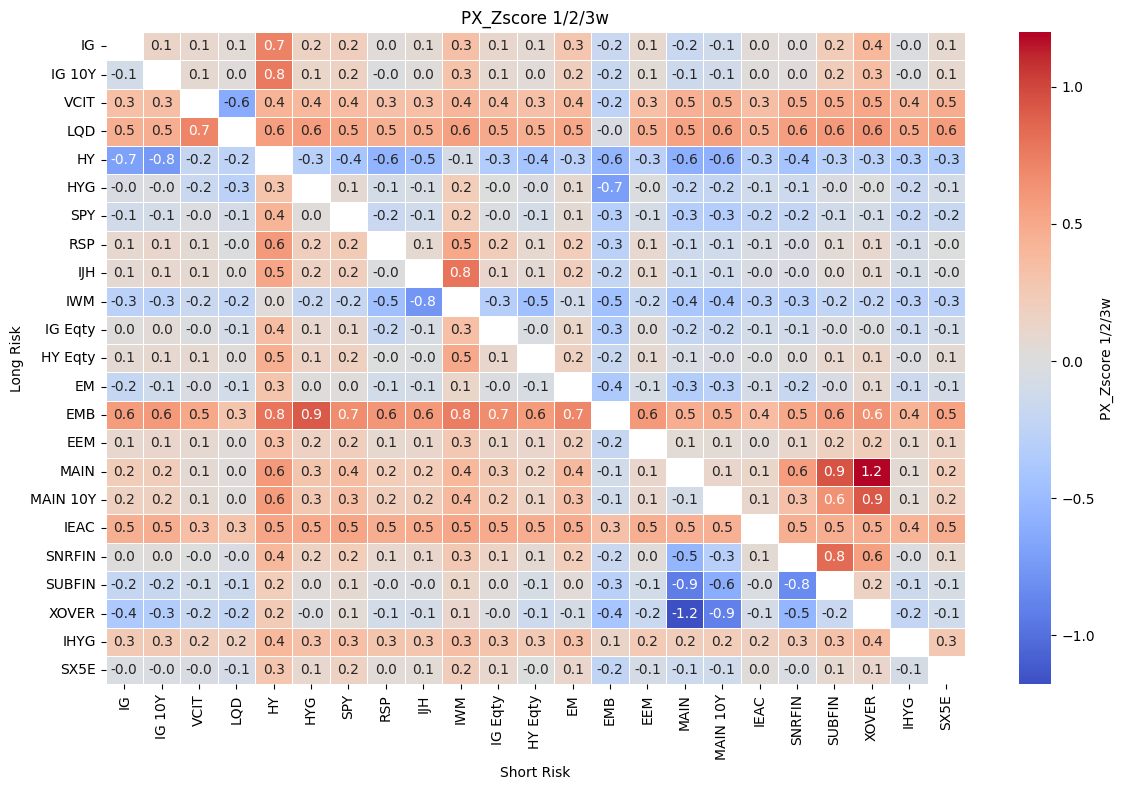

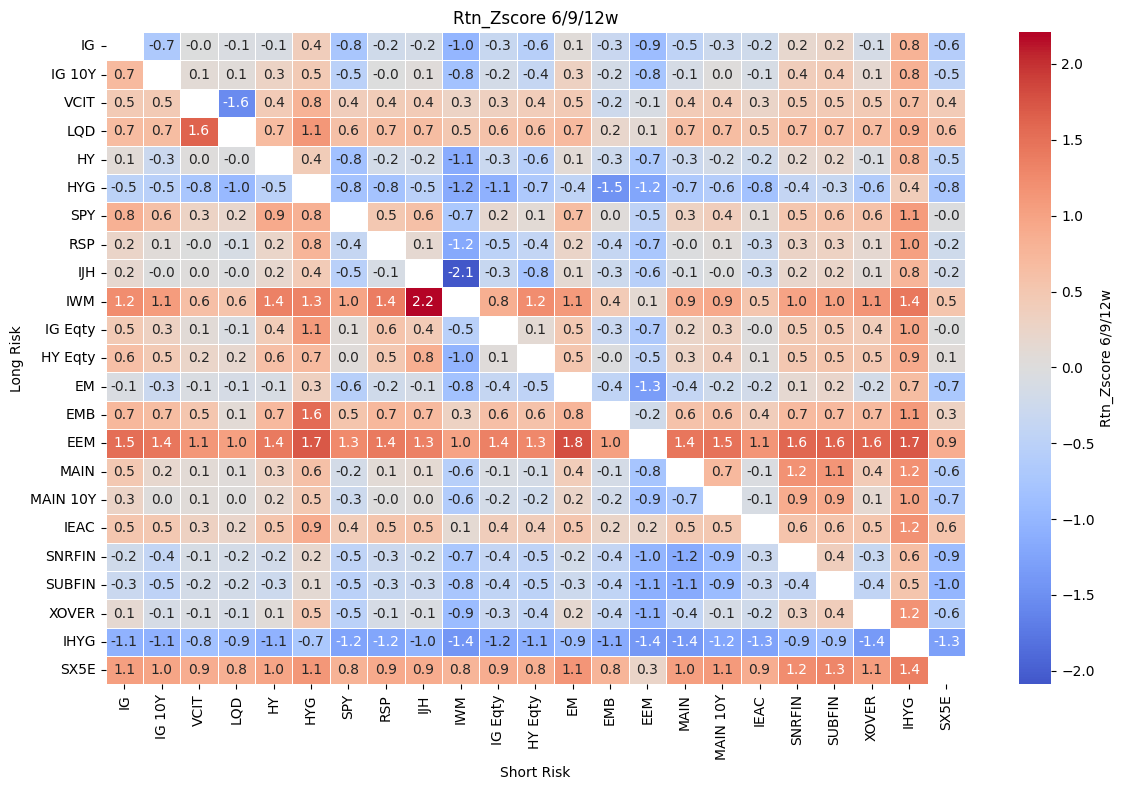

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO
import re
import os

def _clean_key_series(s):
    s = s.copy()
    null_mask = s.isna()
    s = s.astype(str)
    s = s.where(~null_mask, np.nan)
    s = s.str.strip()
    s = s.replace({"": np.nan, "nan": np.nan, "NaN": np.nan, "None": np.nan, "NONE": np.nan, "null": np.nan, "NULL": np.nan})
    return s

def _sanitize_filename(name, suffix="_heatmap.png"):
    base = re.sub(r"[^\w\-\.\s]", "_", str(name)).strip()
    base = re.sub(r"\s+", "_", base)
    if not base:
        base = "heatmap"
    return f"{base}{suffix}"

def long_short_heatmap_items1_img(
    dfx,
    items1,
    value_col="PX_Zscore 1/2/3w",
    long_col="Long Risk",
    short_col="Short Risk",
    cmap="coolwarm",
    center=0.0,
    annot=False,
    fmt=".1f",
    figsize=(12,8),
    strict=True,
    mirror_missing=True,
    keep_full_items1=False,
    save=True,
    out_dir="Plots",
    dpi=200
):
    df = dfx[[long_col, short_col, value_col]].copy()
    bad_mask = pd.to_numeric(df[value_col], errors="coerce").isna() & df[value_col].notna()
    if bad_mask.any():
        print("Non-convertible value rows:")
        print(df.loc[bad_mask, [long_col, short_col, value_col]])
        if strict:
            raise ValueError("Non-float entries found in value column.")
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
    df[long_col] = _clean_key_series(df[long_col])
    df[short_col] = _clean_key_series(df[short_col])
    df = df.dropna(subset=[long_col, short_col, value_col])

    items1_clean = pd.Index(_clean_key_series(pd.Series(items1))).dropna().tolist()
    if len(items1_clean) == 0:
        raise ValueError("items1 produced no valid labels after cleaning.")

    df = df[df[long_col].isin(items1_clean) & df[short_col].isin(items1_clean)]

    dup = df.groupby([long_col, short_col]).size()
    if (dup > 1).any():
        dups = dup[dup > 1].index.tolist()
        raise ValueError(f"Duplicate ordered pairs found: {dups}")

    if mirror_missing:
        a = df[long_col].astype(str).to_numpy()
        b = df[short_col].astype(str).to_numpy()
        v = df[value_col].to_numpy()
        existing = set(zip(a, b))
        rev_rows = []
        for ai, bi, vi in zip(a, b, v):
            if (bi, ai) not in existing and bi in items1_clean and ai in items1_clean:
                rev_rows.append({long_col: bi, short_col: ai, value_col: vi})
        if rev_rows:
            df = pd.concat([df, pd.DataFrame(rev_rows)], ignore_index=True)

    if keep_full_items1:
        order = items1_clean
    else:
        present = pd.unique(pd.concat([df[long_col].astype(str), df[short_col].astype(str)], ignore_index=True)).tolist()
        order = [x for x in items1_clean if x in present]
        if len(order) == 0:
            raise ValueError("No labels from items1 are present in the data after cleaning and filtering.")

    df[long_col] = pd.Categorical(df[long_col].astype(str), categories=order, ordered=True)
    df[short_col] = pd.Categorical(df[short_col].astype(str), categories=order, ordered=True)

    dup2 = df.groupby([long_col, short_col]).size()
    if (dup2 > 1).any():
        dups = dup2[dup2 > 1].index.tolist()
        raise ValueError(f"Duplicates after mirroring: {dups}")

    mat = df.pivot(index=long_col, columns=short_col, values=value_col)
    mat = mat.reindex(index=order, columns=order).astype(float)

    fig = plt.figure(figsize=figsize)
    ax = sns.heatmap(mat, cmap=cmap, center=center, annot=annot, fmt=fmt, linewidths=0.5, linecolor="white", cbar_kws={"label": value_col})
    ax.set_xlabel(short_col)
    ax.set_ylabel(long_col)
    ax.set_title(f"{value_col}")
    plt.tight_layout()

    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=dpi, bbox_inches="tight")
    buf.seek(0)

    saved_path = None
    if save:
        os.makedirs(out_dir, exist_ok=True)
        fname = _sanitize_filename(value_col)
        saved_path = os.path.join(out_dir, fname)
        with open(saved_path, "wb") as f:
            f.write(buf.getvalue())

    return mat, ax, buf, saved_path


mat1, ax1, img1, path1 = long_short_heatmap_items1_img(
    dfx, items1, value_col="PX_Zscore 1/2/3w", annot=True, save=True
)


mat2, ax2, img2, path2 = long_short_heatmap_items1_img(
    dfx, items1, value_col="Rtn_Zscore 6/9/12w", annot=True, save=True
)

In [65]:
import os
import win32com.client

folder_path = os.path.join(os.getcwd(), "Plots")

images = [f for f in os.listdir(folder_path) if f.endswith('.png')]

outlook = win32com.client.Dispatch("Outlook.Application")
mail = outlook.CreateItem(0)

html_body = '<html><body>'
for j, image in enumerate(images):
    file_path = os.path.join(folder_path, image)
    if os.path.exists(file_path):
        cid = f'image{j}'
        attachment = mail.Attachments.Add(Source=file_path)
        attachment.PropertyAccessor.SetProperty("http://schemas.microsoft.com/mapi/proptag/0x3712001F", cid)
        html_body += f'<br><br><img src="cid:{cid}"><br>'
    else:
        print(f"File {file_path} not found")

html_body += '</body></html>'
mail.HTMLBody = html_body

mail.Subject = 'RV Matrix (auto)'
mail.CC = 'vasu.sharma@iiicm.com'
if email_both:
    mail.To = 'spyros.michas@iiicm.com'
if send_email:
    mail.Send()
    print("Email sent successfully")

Email sent successfully
